<a href="https://colab.research.google.com/github/sacktock/EDVAM-models/blob/main/RNN_GAN_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **C-RNN-GAN seq2seq model for time series prediction and generation for the EDVAM dataset**

EDVAM: the first 3D eye tracking dataset for a virtual world. https://github.com/YunzhanZHOU/EDVAM

**The Problem:**

We redefine the original problem from a classification task to a spatial regression task. We condiser the following 9 features:


*   3D point of gaze (PoG) [X, Y, Z] - 3 features.
*   Camera position [X, Y, Z] - 3 features.
*   Camera orientation vector [X, Y, Z] - 3 features.

We consider a frame as a 9-tuple of real values for each of these features. Using the EDVAM dataset which consists of time sequences of these frames collected from 63 participants, we train a RNN to predict the next m frames from a sequence of n past frames using a modified version of the generative adversarial method called "Professor Forcing".

We formulate this sequence to sequence (seq2seq) problem with the goal of achieving long term accurate predictions of subsequent visual attention and user orientation into the future.

The Generator network is trained to predict and generate sequences into the future from a source sequence in the expected way. 

However, the goal of the Discriminator network for this setup is to be able to distinguish between predicted trajectories generated in "Teacher Forcing" mode and "Auto-regressive sampling" mode.

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Install Dependencies**

In [ ]:
!pip install livelossplot

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import csv
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Hyper-params**

In [ ]:
BATCH_SIZE = 128
LR = 0.0001

NUM_FEATURES = 9
HIDDEN_DIM = 512
NUM_LAYERS = 2

SEQ_LEN_IN = 300
SEQ_LEN_OUT = 90

**Construct the Dataset**

Using the EDVAM raw subset we construct training examples. Using a sliding window of 10 seconds (300 frames) we generate sequences of frames as training examples, the targets for our training examples are the subsequent 3 seconds worth of frames (90 frames).

In [ ]:
dataset = []

# read in data from the raw EDVAM dataset
for num in range(1, 64):
  dataset.append(np.array(pd.DataFrame(pd.read_csv('drive/My Drive/EDVAM_raw_subset/'+str(num)+'.csv', header=0)).iloc[:,2:11]))

train_set = []
train_targets = []

test_set = []
test_targets = []

test_ids = [54, 40, 38, 52, 62, 58, 46, 12, 24]

for num in range(0, 63):
  if num not in test_ids:
    train_set.extend([np.array(dataset[num][i:i+SEQ_LEN_IN, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN_IN - SEQ_LEN_OUT)])
    train_targets.extend([np.array(dataset[num][i+SEQ_LEN_IN:i+SEQ_LEN_IN+SEQ_LEN_OUT, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN_IN - SEQ_LEN_OUT)])

  else:
    test_set.extend([np.array(dataset[num][i:i+SEQ_LEN_IN, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN_IN - SEQ_LEN_OUT)])
    test_targets.extend([np.array(dataset[num][i+SEQ_LEN_IN:i+SEQ_LEN_IN+SEQ_LEN_OUT, :], dtype=np.float32) for i in range(len(dataset[num]) - SEQ_LEN_IN - SEQ_LEN_OUT)])

train_set = np.array(train_set)
train_targets = np.array(train_targets)

test_set = np.array(test_set)
test_targets = np.array(test_targets)

**Visualizing Time Sequences**

Let's visualize some time sequences from the test data by plotting them on 3D axes. 

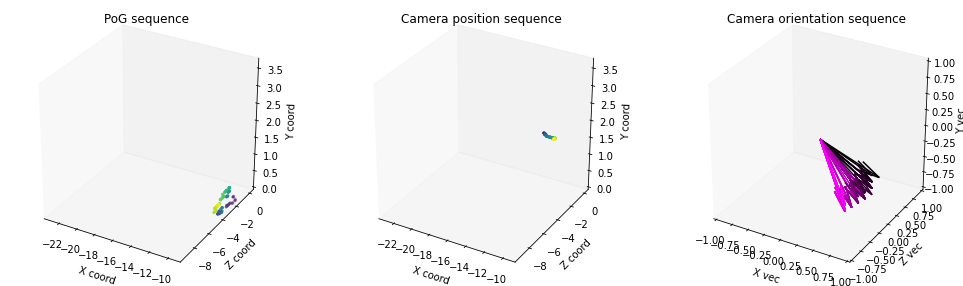

In [ ]:
def plot_seq(arr): # requires non-normalized data
  seq_len = arr.shape[0]

  # PoG (x, y, z)
  x_p = arr[:, 0]
  y_p = arr[:, 1]
  z_p = arr[:, 2]

  # Camera pos (x, y, z)
  x_c = arr[:, 3]
  y_c = arr[:, 4]
  z_c = arr[:, 5]

  # Camera vec (x, y, z)
  x_o = arr[:, 6]
  y_o = arr[:, 7]
  z_o = arr[:, 8]
  
  fig = plt.figure(figsize=(17, 5))

  ax = fig.add_subplot(1,3,1, projection='3d')

  ax.set_title("PoG sequence")
  ax.set_xlabel("X coord")
  ax.set_ylabel("Z coord")
  ax.set_zlabel("Y coord")

  ax.set_xlim(-23.4, -9)
  ax.set_zlim(0,3.7)
  ax.set_ylim(-9.7,0.4)

  ax.grid(False)
  ax.scatter(x_p,z_p,y_p, c=np.arange(seq_len, seq_len*2), marker='.')

  ax = fig.add_subplot(1,3,2, projection='3d')

  ax.set_title("Camera position sequence")
  ax.set_xlabel("X coord")
  ax.set_ylabel("Z coord")
  ax.set_zlabel("Y coord")

  ax.set_xlim(-23.4, -9)
  ax.set_zlim(0,3.7)
  ax.set_ylim(-9.7,0.4)

  ax.grid(False)
  ax.scatter(x_c,z_c,y_c, c=np.arange(seq_len, seq_len*2), marker='.')

  ax = fig.add_subplot(1,3,3, projection='3d')

  ax.set_title("Camera orientation sequence")
  ax.set_xlabel("X vec")
  ax.set_ylabel("Z vec")
  ax.set_zlabel("Y vec")

  ax.set_xlim(-1, 1)
  ax.set_zlim(-1,1)
  ax.set_ylim(-1,1)

  ax.grid(False)
  # visualize camera orientations as unit vectors
  ax.quiver(np.zeros_like(90,), np.zeros_like(90,), np.zeros_like(90,), x_o, y_o, z_o, 
            colors=[(col, 0, col) for col in np.arange(0,1.0,step=(1/seq_len))])

  plt.show()

idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - SEQ_LEN_OUT)

plot_seq(np.array(dataset[idx][start:start+SEQ_LEN_OUT, :]))

**Normalize the Data**

We normalize the data so that no feature takes priority over the other when training the network.

In [ ]:
means = np.array([[[-14.36113819,   1.6289878,   -4.3960396,  -16.36456295,   1.71260748,
                     -4.05706022,   0.49849881,  -0.03998035,  -0.03879195]]], dtype=np.float32)

stds = np.array([[[4.03698547, 0.8635303,  2.79440592, 2.69018196, 0.06613871, 1.5993084,
                   0.65815014, 0.17796627, 0.54445267]]], dtype=np.float32)

 # normalize both datasets using pre-computed means and stds
train_set = (train_set - means) / stds
train_targets = (train_targets - means) / stds

test_set = (test_set - means) / stds
test_targets = (test_targets - means) /stds

**Setup the Dataloaders**

In [ ]:
# wrap data in tensors and init data loaders
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_data = TensorDataset(torch.from_numpy(train_set), torch.from_numpy(train_targets))
test_data = TensorDataset(torch.from_numpy(test_set), torch.from_numpy(test_targets))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

train_iter = iter(cycle(train_loader))
test_iter = iter(cycle(test_loader))

**Define the Generator Model**

To implement the generator we use gated recurrent units (GRUs) to construct a generative recurrent neural network (RNN). We use the Encoder-Decoder model architecture that has been successful for Image Captioning, NLP, and some real valued tasks. 

The Encoder processes the sequence input through 2 layers of GRUs at each timestep and constructs a context vector which is then fed to the Decoder. The Decoder passes the context vector (last Encoder state) as input and outputs m predicted frames. We use just a single GRU cell fitted with a linear output layer to implement the Decoder.

The most stable Generator parameters we found so far are as follows:

*   Hidden size = 512
*   Number of (Encoder) GRU layers = 2
*   Dropout (Encoder) = 0.0
*   Dropout (Decoder) = 0.0





In [ ]:
class DecoderCell(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, dropout=0):
      super().__init__()
      self.cell = nn.GRUCell(input_size, hidden_dim)
      self.out = nn.Linear(hidden_dim, output_size)
      self.dropout = nn.Dropout(dropout)

      self.init_weights()

  def init_weights(self):
    initrange = 0.1
    self.out.bias.data.zero_()
    self.out.weight.data.uniform_(-initrange, initrange)

  def forward(self, prev_hidden, y):
    hidden = self.cell(y, prev_hidden)
    output = self.out(hidden)
    return output, self.dropout(hidden)

class Generator(nn.Module):
  ''' RNN Encoder-Decoder seq2seq architecture'''
  def __init__(self, input_size, output_size, hidden_dim, num_layers, dropout=0):
    super().__init__()    
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.encoder = nn.GRU(input_size, hidden_dim, num_layers, dropout=dropout, batch_first=True)
    self.decoder = DecoderCell(input_size, output_size, hidden_dim)

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(device)
    return hidden

  def forward(self, x, future=0, y=None):
    x = x.float()
    batch_size = x.shape[0]

    hidden = self.init_hidden(batch_size)

    # pass the input sequence through the encoder to get the context vector
    encoder_out, encoder_hidden = self.encoder(x, hidden)

    # context vector for Decoder input
    prev_hidden = encoder_hidden[-1]

    outputs = []
    hiddens = []

    # we need to pass an input frame into the Decoder to start decoding
    y_prev = x[:, -1]

    for i in range(future):
      if (y is not None) and (i > 0):
        y_prev = y[:, i-1]

      decoder_out, prev_hidden = self.decoder(prev_hidden, y_prev)
      y_prev = decoder_out
      outputs += [decoder_out]
      hiddens += [prev_hidden]

    outputs = torch.stack(outputs, 1)
    hiddens = torch.stack(hiddens, 1)
    return outputs, hiddens

input_size = NUM_FEATURES
output_size = NUM_FEATURES

G = Generator(input_size, output_size, HIDDEN_DIM, NUM_LAYERS).to(device)
optim_g = torch.optim.Adam(G.parameters(), lr=LR, amsgrad=True) # SGD gives us poor convergence
liveplot = PlotLosses()

**Define the Discriminator Model**

The Discriminator is also a RNN and we implement it with GRUs, it has more parameters and operates in different way to the Generator. As input it takes a sequence of Generator outputs (9-tuples) concatenated with the ground truth targets (conditional GAN). 

We process the the Generator output and ground truth targets forward and backward through time by running two RNNs simultaneously (bidirectional). After processing the sequence of outputs and ground truth targets we concatenate the hidden states of the two RNNs and pass it through a Multi-layer preceptron (MLP) fitted with a sigmoid output (for binary classification).

The most stable Discriminator parameters we found so far are as follows:

*   Hidden size = 512
*   Number of GRU layers = 2
*   Dropout = 0.0


In [ ]:
class Discriminator(nn.Module):

  def __init__(self, input_size, output_size, hidden_dim, num_layers, dropout=0):
    super().__init__()    
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    # bidriectional RNNs
    self.gru = nn.GRU(input_size, hidden_dim, self.num_layers, dropout=dropout, bidirectional=True, batch_first=True)
    # MLP layers
    self.classifier = nn.Sequential(
      nn.Linear(self.hidden_dim * 2, 90),
      nn.LeakyReLU(0.2),
      nn.Linear(90, 90),
      nn.LeakyReLU(0.2),
      nn.Linear(90, output_size),
      nn.Sigmoid(),
    )

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = weight.new(2*self.num_layers, batch_size, self.hidden_dim).zero_().to(device)
    return hidden

  def forward(self, inputs, targets):
    batch_size = inputs.shape[0]

    # initial hidden state 
    hidden = self.init_hidden(batch_size)

    gru_out, hidden = self.gru(torch.cat((inputs,targets), dim=2), hidden)
    output = self.classifier(gru_out[:, -1])

    return output

input_size = NUM_FEATURES * 2
output_size = 1

D = Discriminator(input_size, output_size, HIDDEN_DIM, 2).to(device)
optim_d = torch.optim.Adam(D.parameters(), lr=LR, amsgrad=True) # SGD gives us poor convergence
liveplot = PlotLosses()

In [ ]:
print(f'> Number of generator parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
print(f'> Number of discriminator parameters {len(torch.nn.utils.parameters_to_vector(D.parameters()))}')

> Number of generator parameters 3187209
> Number of discriminator parameters 6459571


**Define the Criterion**

We won't train with MSE loss (as with typical regerssion tasks) instead we will introduce a different loss term called "frame loss". Our objective is to minimze the PoG error, camera position error, and camera orientation error by calculating the 3D distance between the target frames and the predicted frames. 

Note: training with nn.MSELoss was much more unstable and had a worse convergence.

In [ ]:
class frame_loss(nn.Module):
  def __init__(self):
    super(frame_loss, self).__init__()
 
  def forward(self, inputs, targets):
    # sum of geometric error for PoGs
    loss = torch.sqrt(torch.square(targets[:, :, 0:3] - inputs[:, :, 0:3]).sum(axis=2)).sum()
    # sum of geometric error for camera pos
    loss += torch.sqrt(torch.square(targets[:, :, 3:6] - inputs[:, :, 3:6]).sum(axis=2)).sum()
    # sum of geometric error for camera orientation
    loss += torch.sqrt(torch.square(targets[:, :, 6:9] - inputs[:, :, 6:9]).sum(axis=2)).sum()
        
    return loss

**Training Code**

We implement the slightly modified "Professor Forcing" algorithm below. We first fetch a batch of training examples and targets, we pass and input batch to the Generator along with the expected targets and the Generator outputs its prediction for the future 90 frames in "Teacher Forcing" mode (use the ground truth targets as inputs to the Decoder).

We then pass the same input batch to the Generator but without the targets and the Generator outputs its prediction for the next 90 frames in "Auto-regressive sampling" mode (outputs of the Decoder are passed as inputs to the Decoder). 

Next, we pass the Generator outputs with the targets (conditional GAN setup) and calculate the Discriminator loss. We backpropogate the loss to the Discriminator and update the Discriminator parameters - training it to differentiate between "Teacher Forcing" mode outputs and "Auto-regressive sampling" mode outputs given the targets.

We train the Generator as you might expect - to minimize the frame loss between the ground truth 90 frames (y targets) and the predicted 90 frames in "Teacher forcing" mode and in "Auto-regressive sampling" mode. 

If the Discriminator has above 75% accuracy then we backpropogate an additional loss terms to encourage the Generator to beat the Discriminator by ensuring the outputs for both "Teacher Forcing" and "Auto-regressive sampling" look similar.

We also track the validation (mse) loss to check that the Generator doesn't diverge.

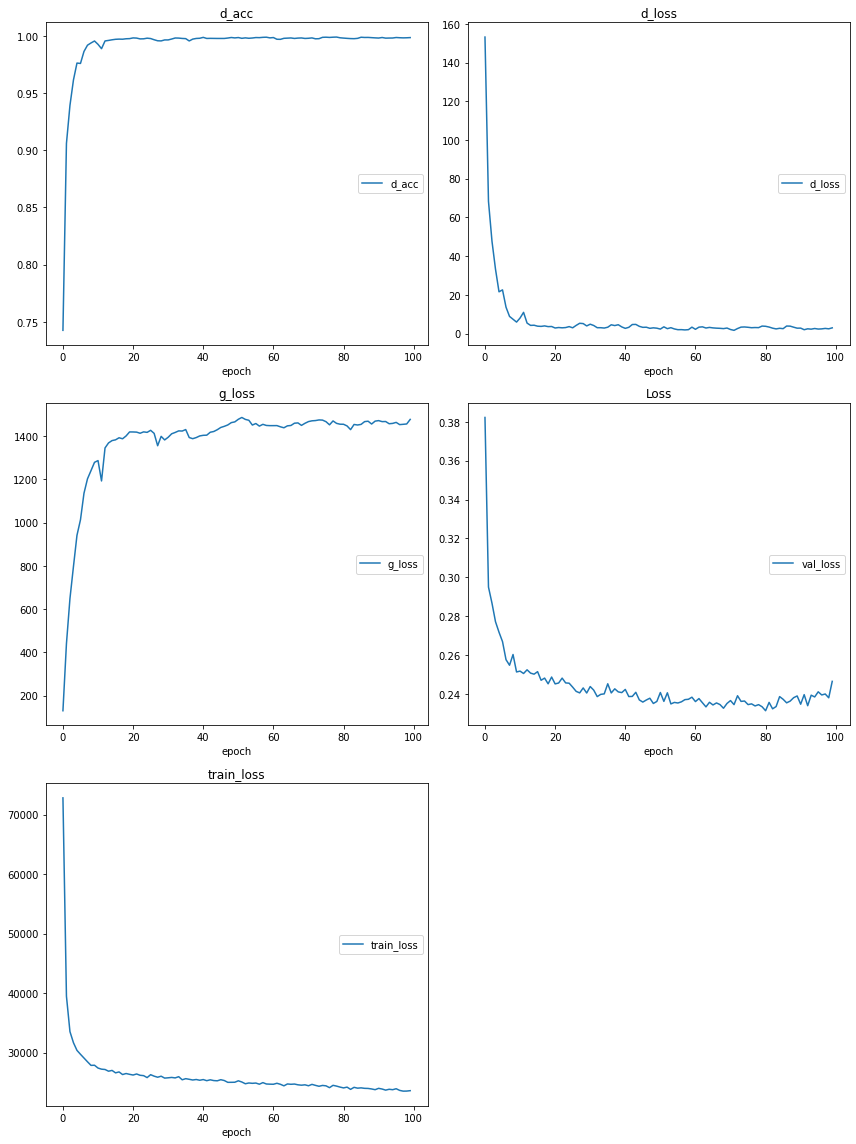

d_acc
	d_acc            	 (min:    0.743, max:    0.999, cur:    0.998)
d_loss
	d_loss           	 (min:    1.695, max:  153.138, cur:    2.982)
g_loss
	g_loss           	 (min:  129.744, max: 1487.043, cur: 1478.046)
Loss
	val_loss         	 (min:    0.231, max:    0.382, cur:    0.246)
train_loss
	train_loss       	 (min: 23542.683, max: 72805.532, cur: 23621.189)
Step 100/100, train_loss: 23621.188867, val_loss: 0.246477, best_val_loss: 0.231359, best_epoch: 81


In [ ]:
step = 0
best_val_loss = np.inf
best_epoch = 0

while (step < 100): 

  fr_loss_arr = np.zeros(0)
  d_loss_arr = np.zeros(0)
  d_acc_arr = np.zeros(0)
  g_loss_arr = np.zeros(0)
  val_loss_arr = np.zeros(0)

  G.train()

  for _ in range(100):
    x, y = next(train_iter)
    x, y = x.to(device), y.to(device)

    out_tf, hid_tf = G(x, future=SEQ_LEN_OUT, y=y)
    out_ar, hid_ar = G(x, future=SEQ_LEN_OUT)

    tf_scores = D(out_tf, y)
    ar_scores = D(out_ar, y)

    correct = float((tf_scores > 0.5).sum() + (ar_scores < 0.5).sum())
    d_accuracy = correct / (tf_scores.shape[0] * 2)

    d_loss = (torch.log(tf_scores) * (-1) + torch.log(1 - ar_scores) * (-1)).sum()

    optim_d.zero_grad()
    # discriminator update step
    if d_accuracy < 0.99:
      d_loss.backward()
      optim_d.step()

    out_tf, hid_tf = G(x, future=SEQ_LEN_OUT, y=y)
    out_ar, hid_ar = G(x, future=SEQ_LEN_OUT)

    tf_scores = D(out_tf, y)
    ar_scores = D(out_ar, y)

    correct = float((tf_scores > 0.5).sum() + (ar_scores < 0.5).sum())
    d_accuracy = correct / (tf_scores.shape[0] * 2)

    optim_g.zero_grad()
    # generator update step
    if d_accuracy > 0.75:
      fr_loss = frame_loss()(out_tf, y) + frame_loss()(out_ar, y)
      g_loss = (torch.log(ar_scores) * (-1)).sum()
      fr_loss.backward(retain_graph=True)
      g_loss.backward()
    else:
      fr_loss = frame_loss()(out_tf, y) + frame_loss()(out_ar, y)
      g_loss = (torch.log(ar_scores) * (-1)).sum()
      fr_loss.backward()

    optim_g.step()

    d_loss_arr = np.append(d_loss_arr, d_loss.item())
    d_acc_arr = np.append(d_acc_arr, d_accuracy)
    fr_loss_arr = np.append(fr_loss_arr, fr_loss.item())
    g_loss_arr = np.append(g_loss_arr, g_loss.item())

  G.eval()

  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)

      out, _ = G(x, future=SEQ_LEN_OUT)

      val_loss = nn.MSELoss()(out, y)

      val_loss_arr = np.append(val_loss_arr, val_loss.item())

  step += 1

  val_losses = val_loss_arr.mean()
  d_losses = d_loss_arr.mean()
  fr_losses = fr_loss_arr.mean()
  g_losses = g_loss_arr.mean()
  d_accuracy = d_acc_arr.mean()

  if val_losses < best_val_loss:
    best_epoch = step
    best_val_loss = val_losses
    torch.save({'Generator':G.state_dict()}, 'drive/My Drive/training/G.chkpt')
    torch.save({'Discriminator':D.state_dict()}, 'drive/My Drive/training/D.chkpt')

  liveplot.update({"val_loss" : val_losses, "d_loss" : d_losses, "d_acc" : d_accuracy, "train_loss" : fr_losses, "g_loss" : g_losses})
  liveplot.send()

  print('Step {}/{}, train_loss: {:.6f}, val_loss: {:.6f}, best_val_loss: {:.6f}, best_epoch: {}'.format(step, 100, fr_losses, val_losses, best_val_loss, best_epoch))


**Model Validation**

Let's load our best Generator model and see how well it does on unseen data in "Auto-regressive sampling" mode.

In [ ]:
try:
  params = torch.load('drive/My Drive/training/G.chkpt')
  G.load_state_dict(params['Generator'])
except:
  print('Failed to load best model ... using current model')

G.eval()

val_loss_arr = np.zeros(0)

for x, y in test_loader:
  x, y = x.to(device), y.to(device)
  y_hat, _ = G(x, future=SEQ_LEN_OUT)
  val_loss = nn.MSELoss()(y_hat, y)
  val_loss_arr = np.append(val_loss_arr, val_loss.item())

print('val loss {:.6f}'.format(val_loss_arr.mean()))

val loss 0.231327


# Evaluate the model

Let's load our model and have a look at some regression metrics and accuracy scores for each of the features.

In [ ]:
futures = [1, 5, 10, 45, 90] # how good is the model at predicting into the future

df_m = pd.DataFrame(index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
df_p = pd.DataFrame(index=["<.5m","<1m", "<2m", "<5m"])
df_c = pd.DataFrame(index=["<.5m","<1m", "<2m", "<5m"])
df_v = pd.DataFrame(index=["<1 deg", "<5 deg", "<10 deg", "<30 deg"])

for future in futures:
  actual, predicted = [], []

  with torch.no_grad():
    for idx in test_ids:
      for start in range(0, dataset[idx].shape[0] - SEQ_LEN_IN - BATCH_SIZE - future, BATCH_SIZE):

        inputs = np.array([np.array(dataset[idx][start+i:start+i+SEQ_LEN_IN, :], dtype=np.float32) for i in range(BATCH_SIZE)])
        targets = np.array([np.array(dataset[idx][start+i+SEQ_LEN_IN+future-1, :], dtype=np.float32) for i in range(BATCH_SIZE)])

        # transform input
        inputs = (inputs - means) / stds
        inputs = torch.tensor(inputs).to(device)

        outputs, _ = G(inputs, future=future)
        outputs = outputs[:, -1].data.cpu().numpy() # we only care about the last frame prediction

        # inverse transform output
        predicted += (outputs * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)).tolist()

        actual += targets.tolist()

  actual, predicted = np.array(actual), np.array(predicted)

  N = actual.shape[0]

  # point of gaze accuracy measures (in meters)
  pog_error = np.sqrt(np.square(actual - predicted)[:, 0:3].sum(axis=1))
  pog_accuracy = [100 * np.array([1 if error < dist else 0 for error in pog_error]).sum() / N for dist in [.5, 1., 2., 5.]]

  # camera position accuracy measures (in meters)
  cam_error = np.sqrt(np.square(actual - predicted)[:, 3:6].sum(axis=1))
  cam_accuracy = [100 * np.array([1 if error < dist else 0 for error in cam_error]).sum() / N  for dist in [.5, 1., 2., 5.]]

  # camera orientation error (in degrees)
  vec_error = np.arccos((actual[:, 6] * predicted[:, 6] + actual[:, 7] * predicted[:, 7] + actual[:, 8] * predicted[:, 8])
              / (np.sqrt((actual[:, 6]**2 + actual[:, 7]**2 + actual[:, 8]**2) * (predicted[:, 6]**2 + predicted[:, 7]**2 + predicted[:, 8]**2))))
  # convert from radians to degrees
  vec_error = vec_error * 180 / np.pi
  vec_error = [100 * np.array([1 if error < angle else 0 for error in vec_error]).sum() / N  for angle in [1., 5., 10., 30.]]

  # regression metrics
  MSE = (np.square(actual - predicted)).mean(axis=0) # mean squared error
  MAE = (np.abs(actual - predicted)).mean(axis=0) # mean absolute error
                    
  # adjusted R squared correlation coeff for multiple regression
  # each feature is dependent on each feature, but some features are correlated
  N = predicted.shape[0]
  k = predicted.shape[1]
  adj_R2 = []
  corr_matrix = np.corrcoef(predicted, rowvar=False)
  for i in range(k):
    corr_yi = np.corrcoef(predicted, actual[:, i], rowvar=False)
    corr_vec = [corr_yi[j][9] for j in range(k)]

    R2 = np.dot(np.dot(corr_vec, np.linalg.inv(corr_matrix)), corr_vec)

    adj_R2 += [1 - (1 - R2)*((N - 1) / (N - k - 1))]

  df = pd.DataFrame({"MSE" : MSE, "MAE" : MAE, "adj R2" : adj_R2}, 
                    index=["PoG X", "PoG Y", "PoG Z", "Cam X", "Cam Y", "Cam Z", "Cam Vec X", "Cam Vec Y", "Cam Vec Z"])
  df_m = pd.concat([df_m, df], axis=1)

  df = pd.DataFrame({"PoG accuracy" : pog_accuracy}, index=["<.5m", "<1m", "<2m", "<5m"])
  df_p = pd.concat([df_p, df], axis=1)

  df = pd.DataFrame({"Camera accuracy": cam_accuracy}, index=["<.5m", "<1m", "<2m", "<5m"])
  df_c = pd.concat([df_c, df], axis=1)

  df = pd.DataFrame({"Camera vec accuracy" : vec_error}, index=["<1 deg", "<5 deg", "<10 deg", "<30 deg"])
  df_v = pd.concat([df_v, df], axis=1)

In [ ]:
pd.set_option("display.precision", 5)
df_m.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['MSE', 'MAE', 'R2']])
display(df_m)

1 futures                    ... 90 futures                  
                MSE      MAE       R2  ...        MSE      MAE       R2
PoG X       0.89974  0.53740  0.95700  ...    8.03130  2.11479  0.62385
PoG Y       0.13251  0.20111  0.86096  ...    0.69279  0.63884  0.30605
PoG Z       0.33008  0.32583  0.96343  ...    3.16614  1.26286  0.66246
Cam X       0.01682  0.09562  0.99831  ...    1.05169  0.71455  0.88465
Cam Y       0.00003  0.00173  0.90427  ...    0.00038  0.00862  0.10322
Cam Z       0.00923  0.06815  0.99763  ...    0.55462  0.52854  0.84018
Cam Vec X   0.00190  0.03027  0.99734  ...    0.15549  0.25616  0.73884
Cam Vec Y   0.00021  0.00656  0.99287  ...    0.01765  0.08791  0.41848
Cam Vec Z   0.00185  0.02918  0.99528  ...    0.12908  0.24597  0.66618

[9 rows x 15 columns]

In [ ]:
pd.set_option("display.precision", 2)
df_p.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['PoG accuracy']])
display(df_p)

,1 futures,5 futures,10 futures,45 futures,90 futures
,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy,PoG accuracy
<.5m,51.54,31.21,26.39,7.41,3.03
<1m,80.07,64.74,54.88,25.86,13.50
<2m,93.55,86.11,80.71,57.88,40.29
<5m,98.95,97.63,96.65,92.68,86.31


In [ ]:
df_c.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera position accuracy']])
display(df_c)

,1 futures,5 futures,10 futures,45 futures,90 futures
,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy,Camera position accuracy
<.5m,99.47,97.43,92.79,54.46,30.88
<1m,100.00,99.96,99.73,83.70,62.61
<2m,100.00,100.00,100.00,98.09,89.42
<5m,100.00,100.00,100.00,100.00,99.71


In [ ]:
df_v.columns = pd.MultiIndex.from_product([["{} futures".format(future) for future in futures],['Camera vec accuracy']])
display(df_v)

,1 futures,5 futures,10 futures,45 futures,90 futures
,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy,Camera vec accuracy
<1 deg,38.18,21.59,14.73,3.08,0.92
<5 deg,89.94,72.12,58.66,28.56,16.39
<10 deg,99.02,94.34,85.84,52.18,36.48
<30 deg,100.00,100.00,99.73,87.30,71.44


# Having a closer look

The regression metrics are not the whole story, let's have a look at how well the model generates sequences in both "Teacher Forcing" mode and "Auot-regressive smapling" mode.

**Sequence Generation (Teacher Forcing):**

Using the model let's generate a sequence in "Teacher Forcing" mode (with targets).

The following code passed 300 frames of unseen test data and generates 90 frames into the future.

In [ ]:
future = SEQ_LEN_OUT
# genetrate a random test sequence from the test data
idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - SEQ_LEN_IN - future)

inputs = np.array(dataset[idx][start:start+SEQ_LEN_IN, :], dtype=np.float32)
targets = np.array(dataset[idx][start+SEQ_LEN_IN:start+SEQ_LEN_IN+future, :], dtype=np.float32)

# transform input
inputs = (inputs - means) / stds
inputs = torch.tensor(inputs).to(device)

targets = (targets - means) / stds
targets = torch.tensor(targets).to(device)

outputs, _ = G(inputs, future=future, y=targets)

gen_seq = outputs.squeeze(0).data.cpu().numpy()

# cut the first bit of the sequence
actual_seq = targets.squeeze(0).data.cpu().numpy()

# inverse transform the generated sequence
gen_seq = gen_seq * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)

actual_seq = actual_seq * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)

**Plot the 3D point clouds and vectors**

Ground truth:

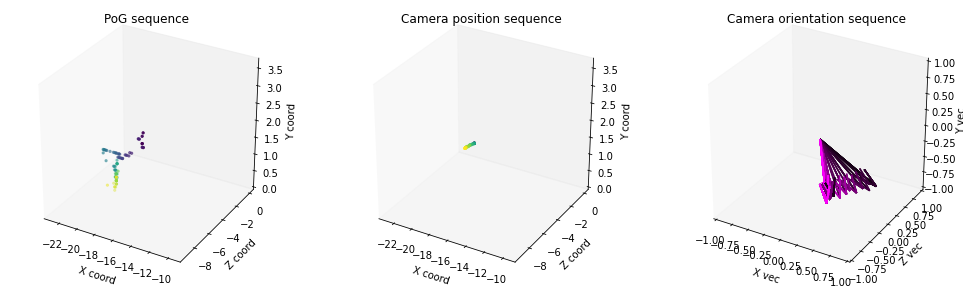

In [ ]:
plot_seq(actual_seq)

Generated sequence:

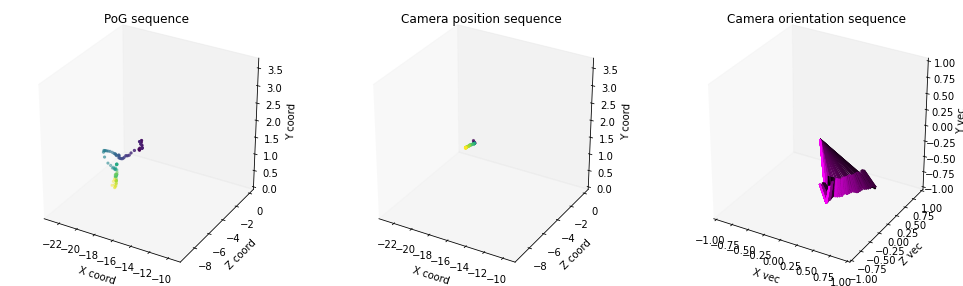

In [ ]:
plot_seq(gen_seq)

**Line plots for each of the 9 features:**

Let's plot the ground truth sequence against the generated sequence for each of the 9 features and see if we got close.

PoG X:

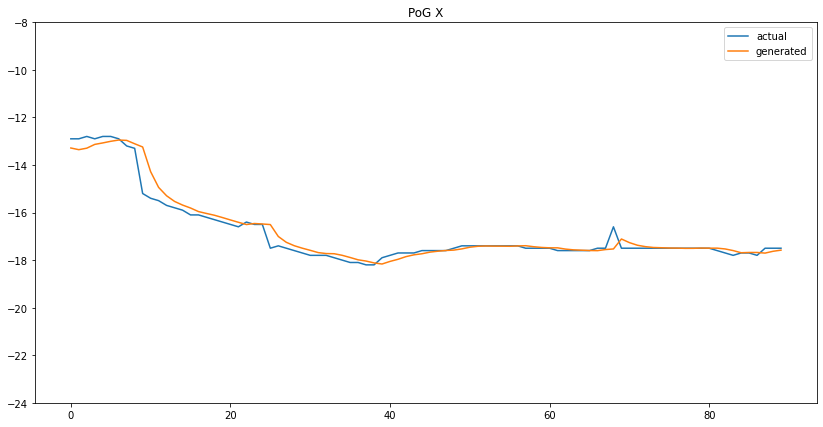

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,0].tolist(), "generated" : gen_seq[:,0].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="PoG X")

PoG Y:

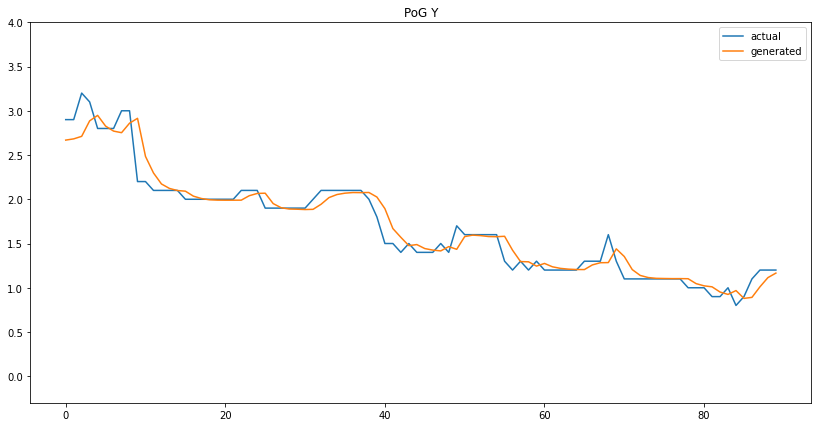

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,1].tolist(), "generated" : gen_seq[:,1].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="PoG Y")

PoG Z:

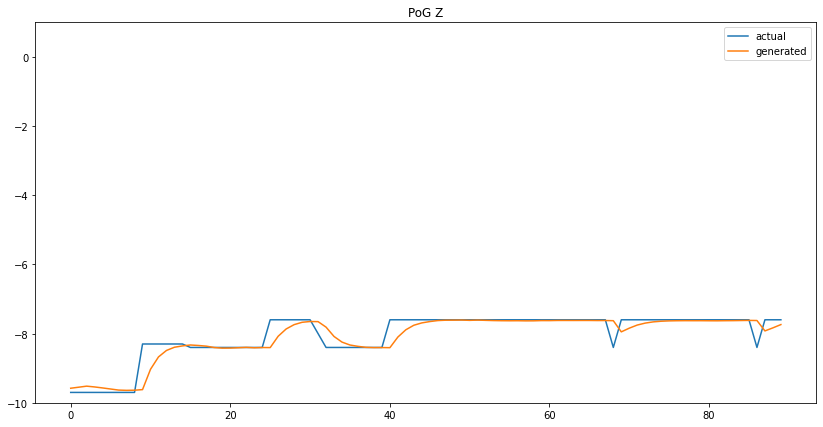

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,2].tolist(), "generated" : gen_seq[:,2].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="PoG Z")

Camera Position X:

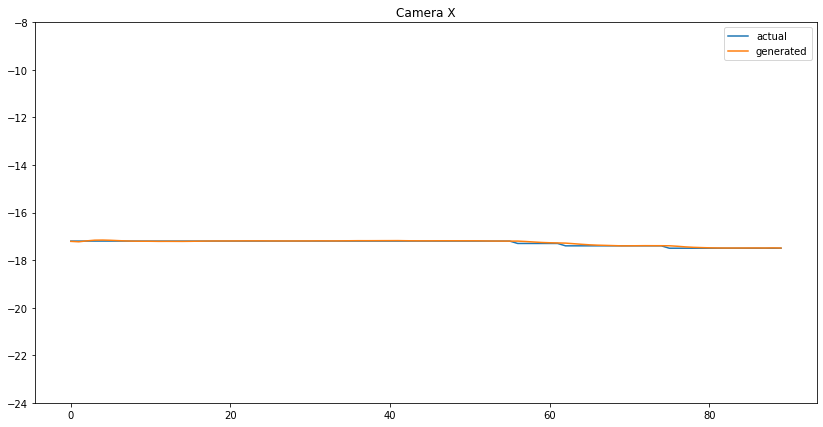

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,3].tolist(), "generated" : gen_seq[:,3].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="Camera X")

Camera Position Y:

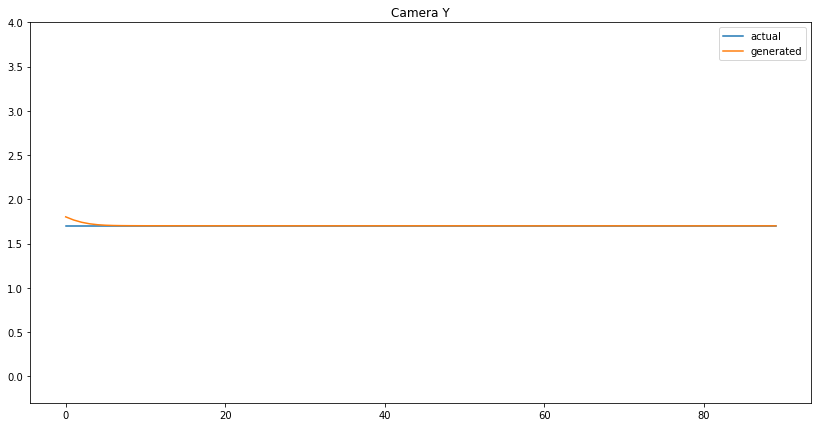

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,4].tolist(), "generated" : gen_seq[:,4].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="Camera Y")

Camera Position Z:

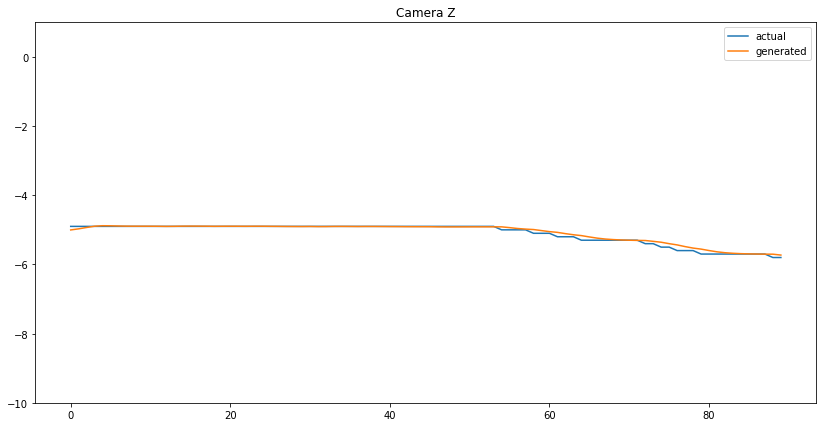

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,5].tolist(), "generated" : gen_seq[:,5].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="Camera Z")

Camera Vector X:

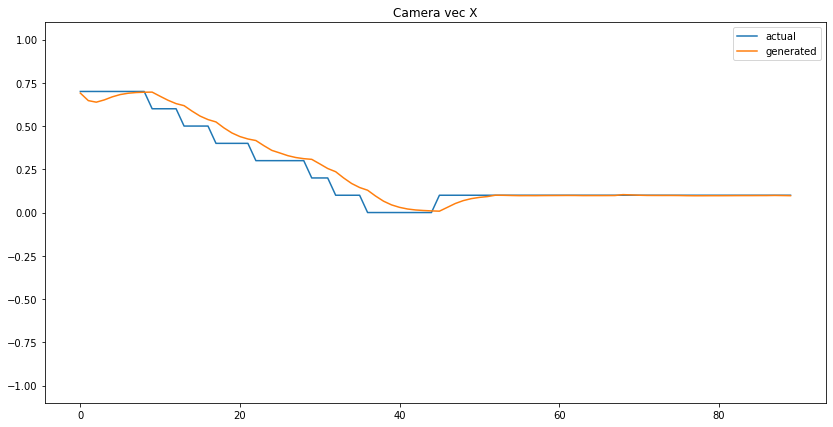

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,6].tolist(), "generated" : gen_seq[:,6].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec X")

Camera Vector Y:

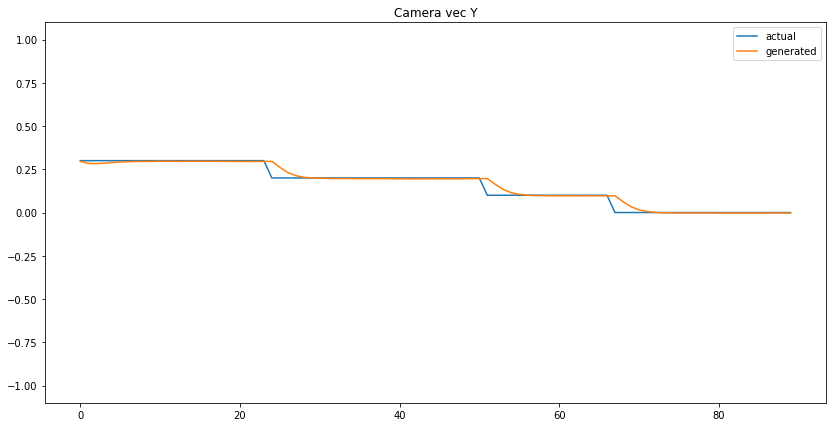

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,7].tolist(), "generated" : gen_seq[:,7].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Y")

Camera Vector Z:

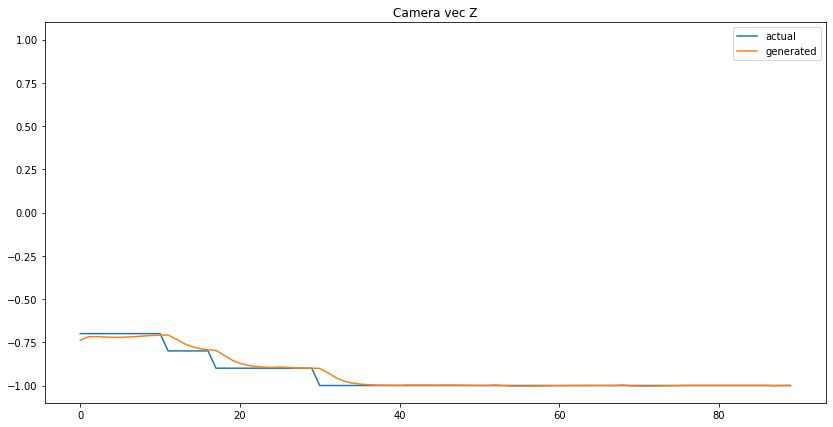

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,8].tolist(), "generated" : gen_seq[:,8].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Z")

**Sequence Generation (Auto-regressive):**

Using the model let's generate a sequence in "Auto-regressive sampling" mode (without targets).

The following code passed 300 frames of unseen test data and generates 90 frames into the future.

In [ ]:
future = SEQ_LEN_OUT
# genetrate a random test sequence from the test data
idx = np.random.choice(test_ids)
start = np.random.randint(0, dataset[idx].shape[0] - SEQ_LEN_IN - future)

inputs = np.array(dataset[idx][start:start+SEQ_LEN_IN, :], dtype=np.float32)
targets = np.array(dataset[idx][start+SEQ_LEN_IN:start+SEQ_LEN_IN+future, :], dtype=np.float32)

# transform input
inputs = (inputs - means) / stds
inputs = torch.tensor(inputs).to(device)

outputs, _ = G(inputs, future=future)

gen_seq = outputs.squeeze(0).data.cpu().numpy()

actual_seq = targets

# inverse transform the generated sequence
gen_seq = gen_seq * np.squeeze(stds, axis=0) + np.squeeze(means, axis=0)

**Plot the 3D point clouds and vectors**

Ground truth:

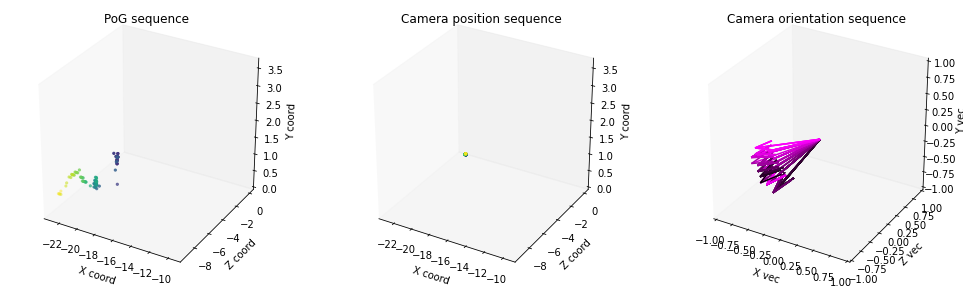

In [ ]:
plot_seq(actual_seq)

Generated sequence:

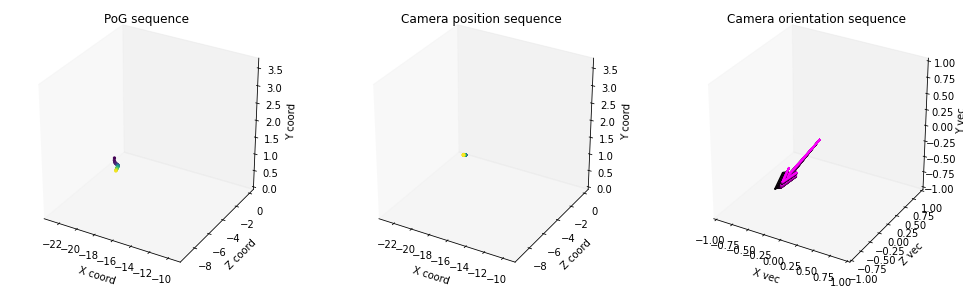

In [ ]:
plot_seq(gen_seq)

**Line plots for each of the 9 features:**

Let's plot the ground truth sequence against the generated sequence for each of the 9 features and see if we got close.

PoG X:

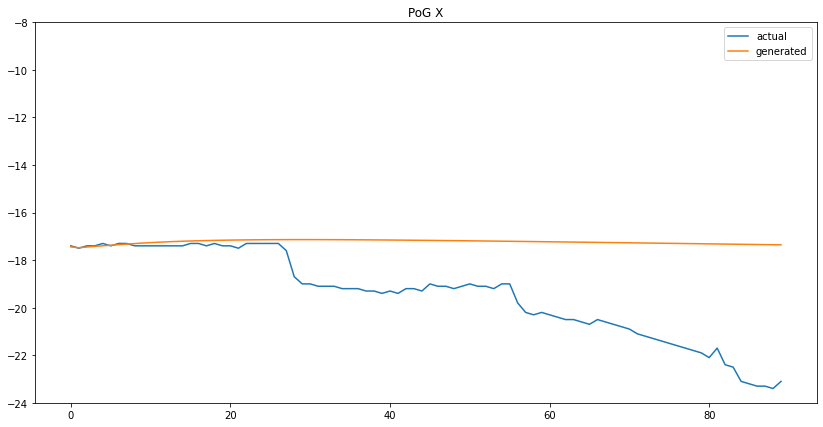

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,0].tolist(), "generated" : gen_seq[:,0].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="PoG X")

PoG Y:

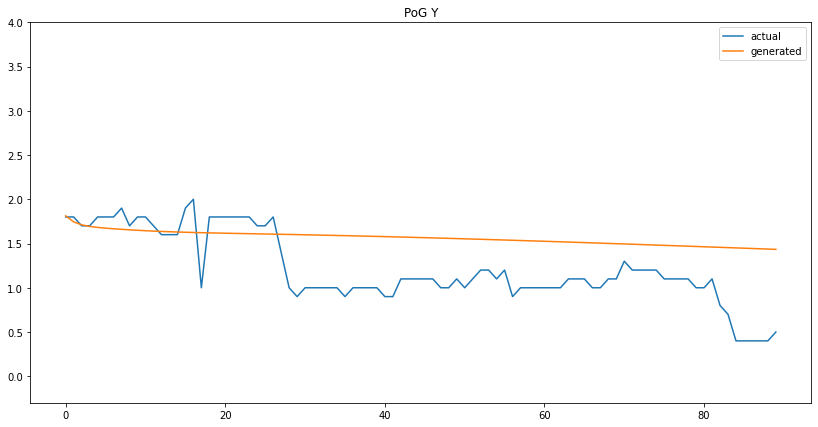

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,1].tolist(), "generated" : gen_seq[:,1].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="PoG Y")

PoG Z:

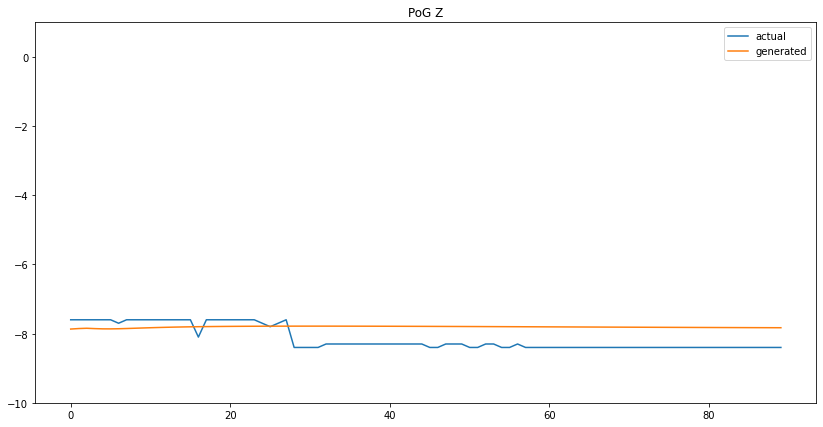

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,2].tolist(), "generated" : gen_seq[:,2].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="PoG Z")

Camera Position X:

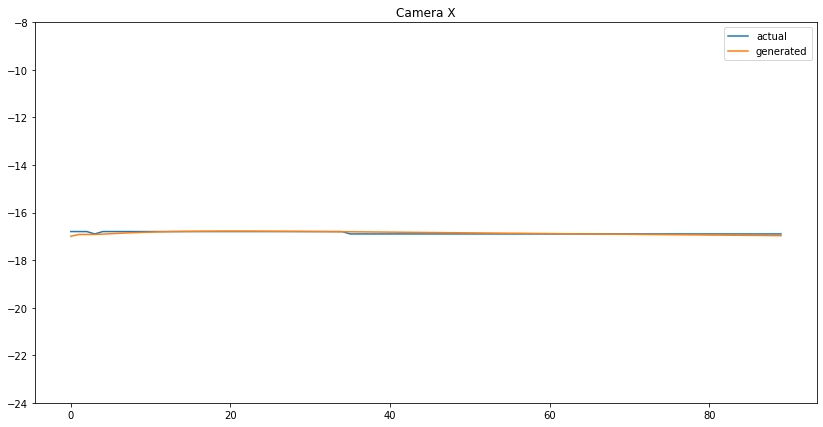

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,3].tolist(), "generated" : gen_seq[:,3].tolist()})
df.plot(figsize=(14,7), ylim=(-24,-8), title="Camera X")

Camera Position Y:

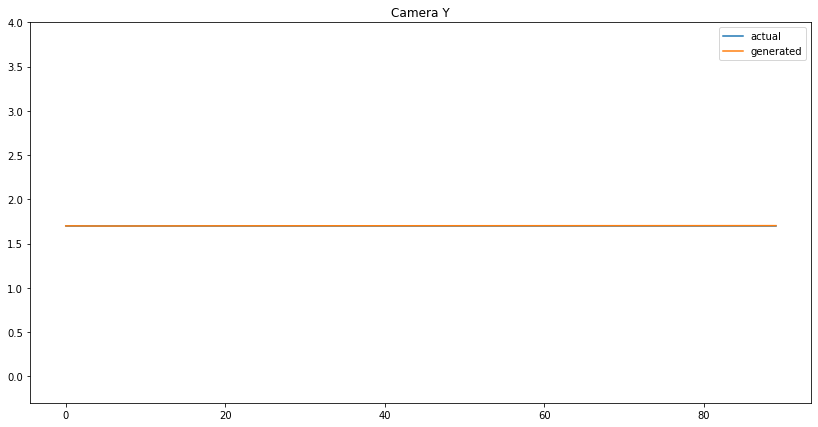

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,4].tolist(), "generated" : gen_seq[:,4].tolist()})
df.plot(figsize=(14,7), ylim=(-0.3,4.0), title="Camera Y")

Camera Position Z:

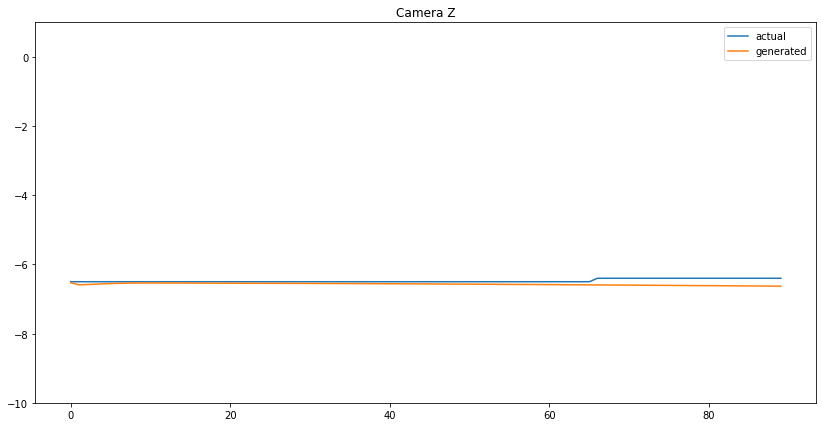

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,5].tolist(), "generated" : gen_seq[:,5].tolist()})
df.plot(figsize=(14,7), ylim=(-10,1), title="Camera Z")

Camera Vector X:

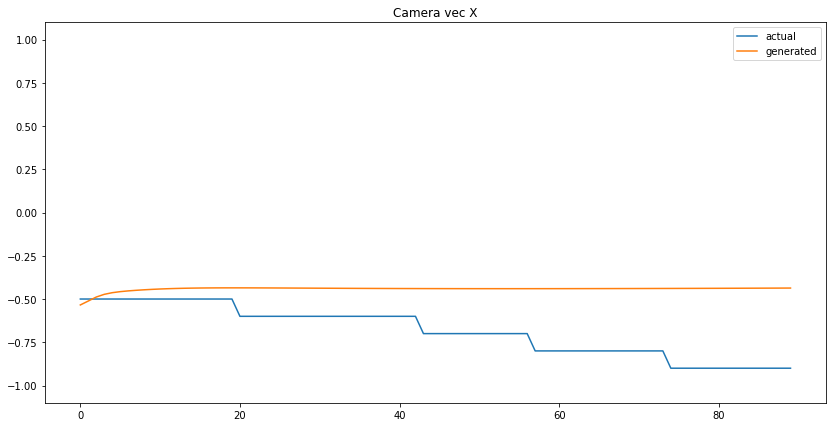

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,6].tolist(), "generated" : gen_seq[:,6].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec X")

Camera Vector Y:

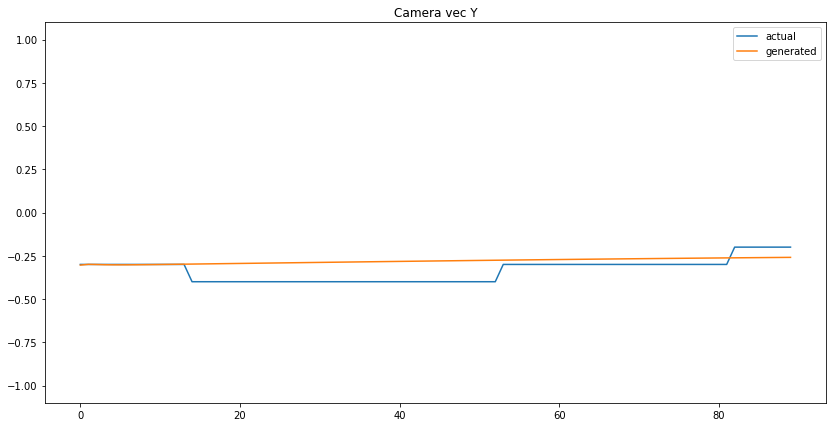

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,7].tolist(), "generated" : gen_seq[:,7].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Y")

Camera Vector Z:

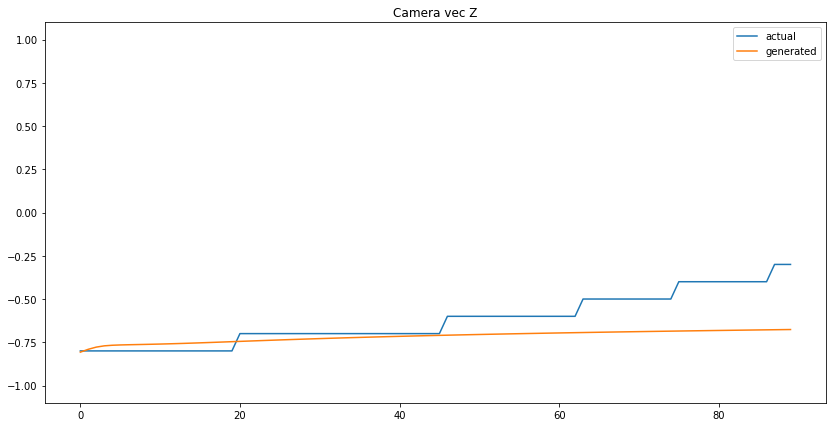

In [ ]:
df = pd.DataFrame({"actual" : actual_seq[:,8].tolist(), "generated" : gen_seq[:,8].tolist()})
df.plot(figsize=(14,7), ylim=(-1.1,1.1), title="Camera vec Z")

**Some obseravtions:**

The idea behind using this adversarial training approach was to encourage the encoder-decoder model to exhibit similar generative behaviour in teacher forcing mode and auto-regressive mode. 

If we look at some of the feature plots we see that the model is still attempting to fit a straight line of best fit to the future trajectories and so the teacher forced sequences still look very much distinguishable from the auto-regressive sequences.

That being said we achieved better validation loss during training and better regression metrics across the board, so to some extent training with "Professor Forcing" was a success.

# Conclusions

It is clear there is still room for improvement, however we need to consider a few things:

*   Perhaps the problem we formulated was not particularly learnable, and we need to go back to the drawing board and formulate the problem in a different way.
*   Perhaps the scheduling of the adversarial training was sub-optimal; better tuning of the hyper parameters and the learning procedure could lead to a better model.
*   Perhaps the generator didn't have enough capacity to capture the shorter-term patterns in the data, or we need to use a more sophisticated model.
*   RL could be applied to the pre-trained generator to help it learn tricky patterns in the data.




